In [1]:
import pandas as pd
import numpy as np
import os
from os.path import exists

import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az

config = {
    'figure.figsize':(14,4),
    'figure.constrained_layout.use':True,
    'figure.facecolor':'w',
    'axes.grid':True,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

In [2]:
CO2_URL = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_annmean_mlo.csv"
CO2_FILENAME = "noaa_co2.csv"
OCEAN_HEAT_URL = "https://www.ncei.noaa.gov/data/oceans/woa/DATA_ANALYSIS/3M_HEAT_CONTENT/DATA/basin/3month/ohc_levitus_climdash_seasonal.csv"
# https://www.ncei.noaa.gov/access/global-ocean-heat-content/basin_heat_data_monthly.html
OCEAN_HEAT_FILENAME = "ncei_global_ocean_heat.csv"

In [3]:
def process_ocean_heat(data_path="../data"):
    if not exists(data_path):
        os.makedirs(data_path)

    if not os.path.isfile(os.path.join(data_path, OCEAN_HEAT_FILENAME)):
        df_ocean = pd.read_csv(OCEAN_HEAT_URL, header=0, names=['Date','Temp'])
        df_ocean.Date = pd.to_datetime(df_ocean.Date, format='%Y-%m')
        df_ocean.set_index("Date", inplace=True)
        df_ocean.to_csv(os.path.join(data_path, OCEAN_HEAT_FILENAME))

    else:
        df_ocean = pd.read_csv(
            os.path.join(data_path, OCEAN_HEAT_FILENAME),
            index_col=["Date"],
            parse_dates=True,
        )

    return df_ocean

In [4]:
def process_co2(data_path="../data"):
    if not exists(data_path):
        os.makedirs(data_path)

    if not os.path.isfile(os.path.join(data_path, CO2_FILENAME)):
        df_co2 = pd.read_csv(CO2_URL, skiprows=43)
        df_co2['month'] = 1
        df_co2['day'] = 1
        df_co2['Date'] = pd.to_datetime(df_co2[['year', 'month', 'day']])
        df_co2.set_index("Date", inplace=True)
        df_co2.rename(columns={"mean": "co2"}, inplace=True)
        df_co2 = df_co2[["co2"]]
        df_co2.to_csv(os.path.join(data_path, CO2_FILENAME))

    else:
        df_co2 = pd.read_csv(
            os.path.join(data_path, CO2_FILENAME), index_col=["Date"], parse_dates=True
        )

    return df_co2

In [5]:
df_ocean = process_ocean_heat()
df_co2 = process_co2()

In [6]:
df_ocean = df_ocean.resample('YE').mean()
df_ocean.reset_index(inplace=True)
df_ocean['Date'] = df_ocean['Date'] - pd.offsets.YearBegin()
df_ocean.set_index("Date", inplace=True)
df_ocean = df_ocean.iloc[1:-1] #Dropping first and last column with incomplete data
df_ocean = df_ocean + 152 #add back in baseline that was subtracted from the data

In [7]:
df_ocean = 100*(df_ocean - df_ocean.mean())/df_ocean.std()
df_co2 = 100*(df_co2 - df_co2.mean())/df_co2.std()

In [8]:
df = pd.DataFrame.merge(df_ocean,df_co2,how='inner',left_index=True, right_index=True).dropna()

# Ocean Quadratic

<Axes: xlabel='Date'>

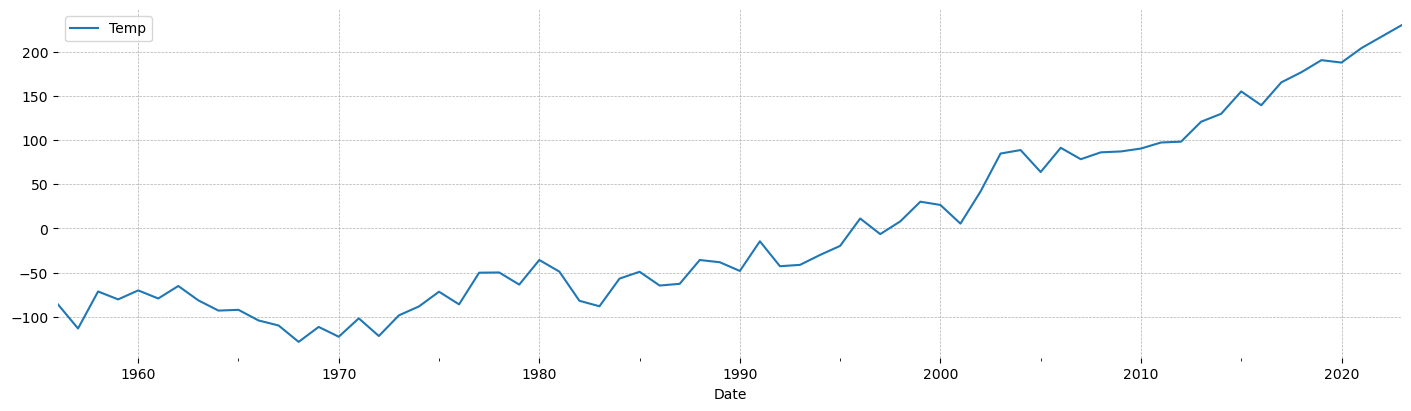

In [9]:
df_ocean.plot()

In [10]:
train_df, test_df = df_ocean.iloc[:round(len(df_ocean)*.85)], df_ocean.iloc[round(len(df_ocean)*.85):]

In [11]:
# We're going to type these a lot...
POST_PRED_KWARGS = dict(return_inferencedata=True, extend_inferencedata=True)

# We need to use "coords_mutable", beause we plan to make forecasts (so we want to change the coords)
coords_mutable = {'time':train_df.index}

with pm.Model(coords_mutable=coords_mutable) as deterministic_trend_mod:
    y_obs = pm.Data('y_obs', train_df.values.ravel())
    
    # Time is just a counter variable, and its actual values don't matter, as long they increase 
    # monotonically in evenly spaced steps. In this case we'll use np.arange to make time. We could
    # just as well use np.linspace. 
    t = pm.Data('t', np.arange(train_df.shape[0]), dims=['time'])
    
    alpha = pm.Normal('alpha', mu=-100, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    delta = pm.Normal('delta', mu=0, sigma=10)
    
    mu = pm.Deterministic('mu', alpha + beta * t + delta * t * t, dims=['time'])
    sigma = pm.HalfNormal('sigma', sigma=1)

    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=y_obs, shape=t.shape[0], dims=['time'])
    
    det_trend_idata = pm.sample()
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, **POST_PRED_KWARGS)

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:518: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:981: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, delta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
Sampling: [y_hat]


Output()

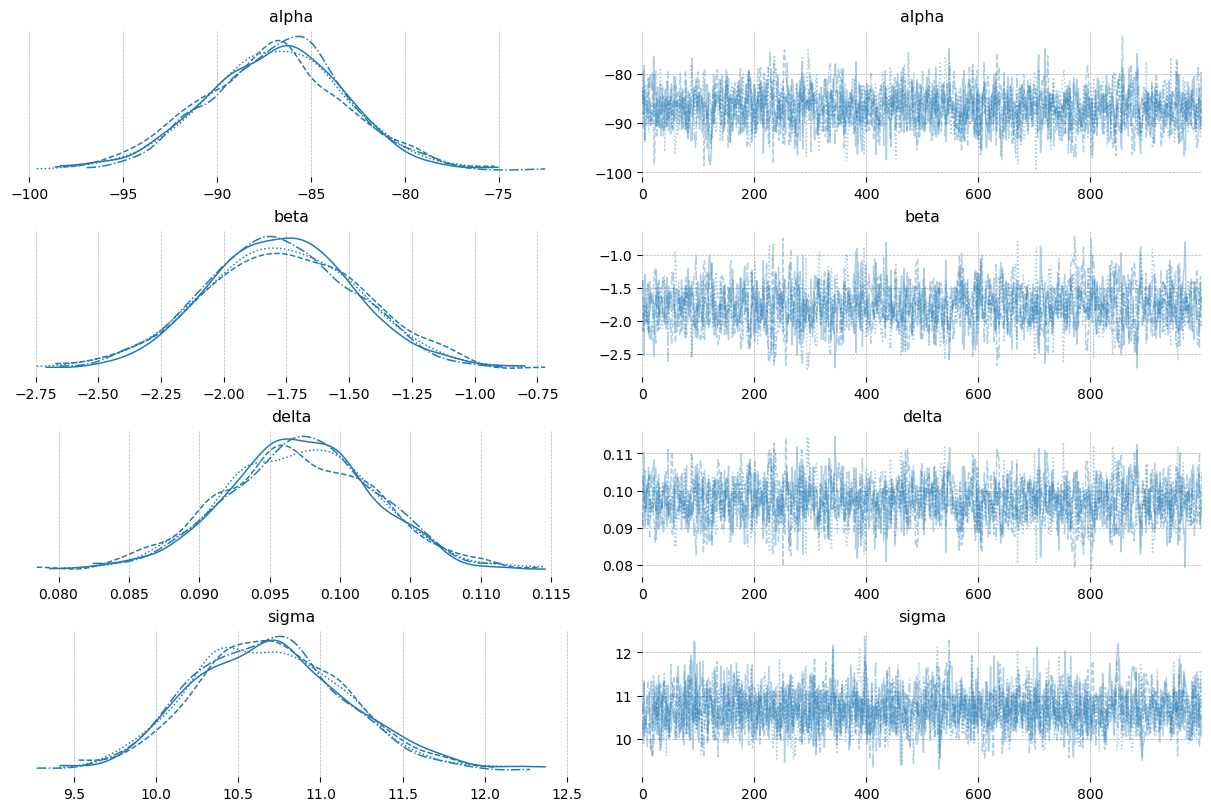

In [12]:
az.plot_trace(det_trend_idata, var_names=['~mu']);

In [13]:
forecast_time = np.arange(train_df.shape[0], train_df.shape[0] + test_df.shape[0])
with deterministic_trend_mod:
    pm.set_data({'t':forecast_time}, coords={'time':test_df.index})
    # Set predictions = True to put the out-of-sample predictions into the idata as a group called
    # "predictions" instead of the default "posterior_predictive"
    # (It doesn't do anything else, so don't think it will do some statistical magic for you!)
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, predictions=True, **POST_PRED_KWARGS)

Sampling: [y_hat]


Output()

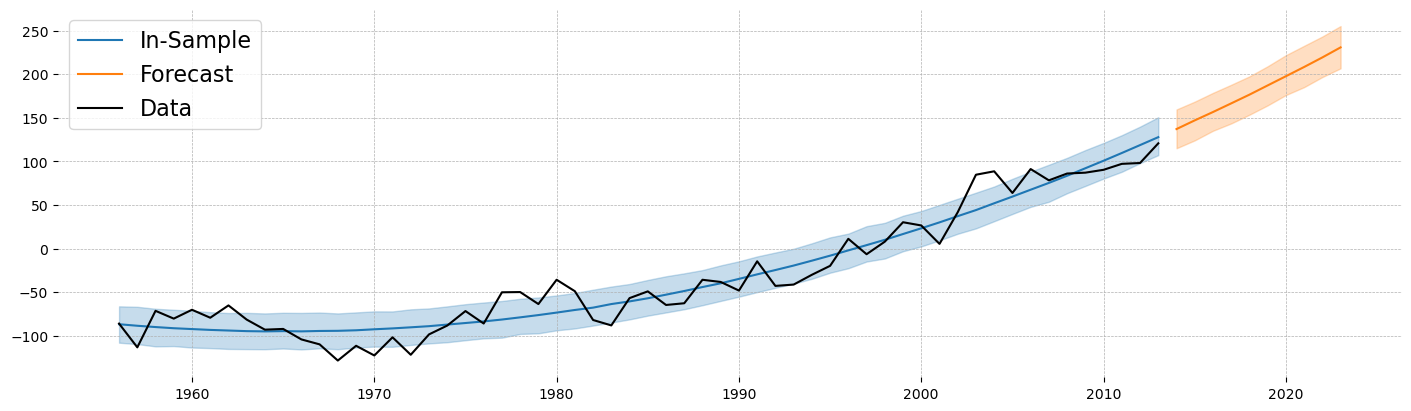

In [14]:
# We'll re-use these
def make_plot_iter():
    plotting_groups = ['posterior_predictive', 'predictions', 'constant_data']
    var_names = ['y_hat', 'y_hat', 'y_obs']
    plotting_colors = ['tab:blue', 'tab:orange', 'k']
    labels = ['In-Sample', 'Forecast', 'Data']
    return zip(plotting_groups, var_names, labels, plotting_colors)

fig, ax = plt.subplots()
for group, var_name, label, var_color in make_plot_iter():
    data = getattr(det_trend_idata, group)
    time_values = data.coords['time'].values
    if group != 'constant_data':
        hdi = az.hdi(data)[var_name]
        data = data.mean(dim=['chain', 'draw'])
        ax.fill_between(time_values, *hdi.values.T, color=var_color, alpha=0.25)
    ax.plot(time_values, data[var_name].values, c=var_color, label=label)
    ax.legend(fontsize=16)

# $CO_2$ Quadratic

<Axes: xlabel='Date'>

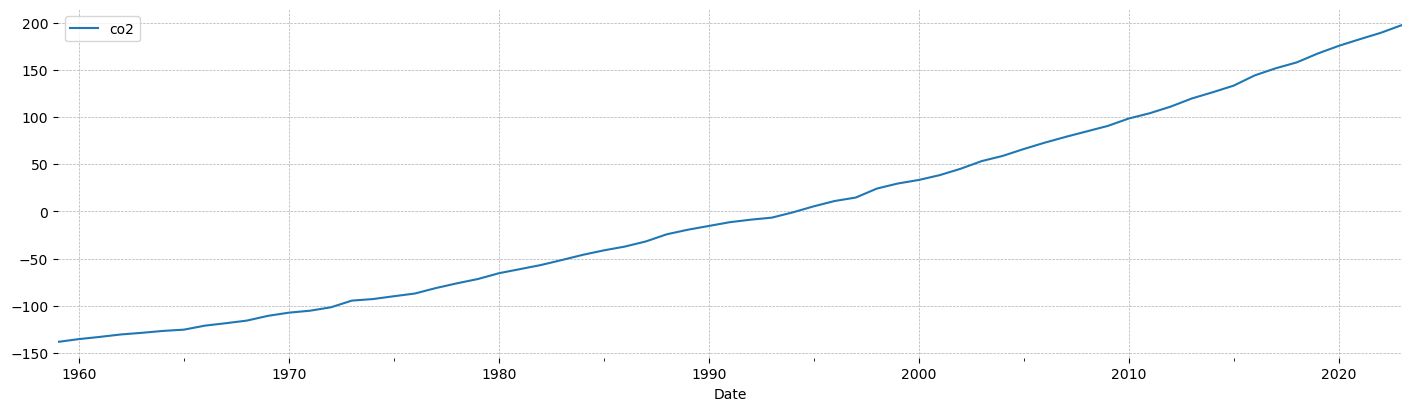

In [15]:
df_co2.plot()

In [16]:
train_df, test_df = df_co2.iloc[:round(len(df_co2)*.85)], df_co2.iloc[round(len(df_co2)*.85):]

In [17]:
# We're going to type these a lot...
POST_PRED_KWARGS = dict(return_inferencedata=True, extend_inferencedata=True)

# We need to use "coords_mutable", beause we plan to make forecasts (so we want to change the coords)
coords_mutable = {'time':train_df.index}

with pm.Model(coords_mutable=coords_mutable) as deterministic_trend_mod:
    y_obs = pm.Data('y_obs', train_df.values.ravel())
    
    # Time is just a counter variable, and its actual values don't matter, as long they increase 
    # monotonically in evenly spaced steps. In this case we'll use np.arange to make time. We could
    # just as well use np.linspace. 
    t = pm.Data('t', np.arange(train_df.shape[0]), dims=['time'])
    
    alpha = pm.Normal('alpha', mu=-150, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    delta = pm.Normal('delta', mu=0, sigma=10)
    
    mu = pm.Deterministic('mu', alpha + beta * t + delta * t * t, dims=['time'])
    sigma = pm.HalfNormal('sigma', sigma=1)

    y_hat = pm.Normal('y_hat', mu=mu, sigma=sigma, observed=y_obs, shape=t.shape[0], dims=['time'])
    
    det_trend_idata = pm.sample()
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, **POST_PRED_KWARGS)

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:518: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pymc/model/core.py:981: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, delta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
Sampling: [y_hat]


Output()

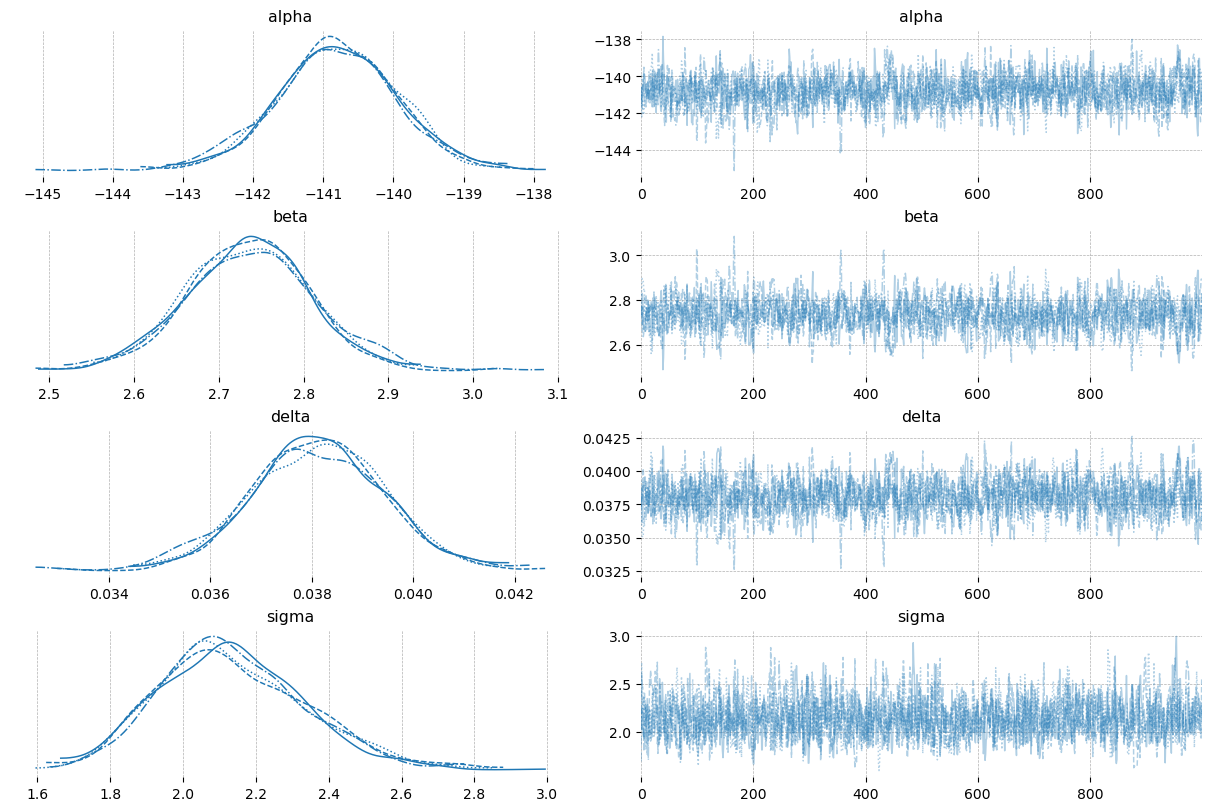

In [18]:
az.plot_trace(det_trend_idata, var_names=['~mu']);

In [19]:
forecast_time = np.arange(train_df.shape[0], train_df.shape[0] + test_df.shape[0])
with deterministic_trend_mod:
    pm.set_data({'t':forecast_time}, coords={'time':test_df.index})
    # Set predictions = True to put the out-of-sample predictions into the idata as a group called
    # "predictions" instead of the default "posterior_predictive"
    # (It doesn't do anything else, so don't think it will do some statistical magic for you!)
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, predictions=True, **POST_PRED_KWARGS)

Sampling: [y_hat]


Output()

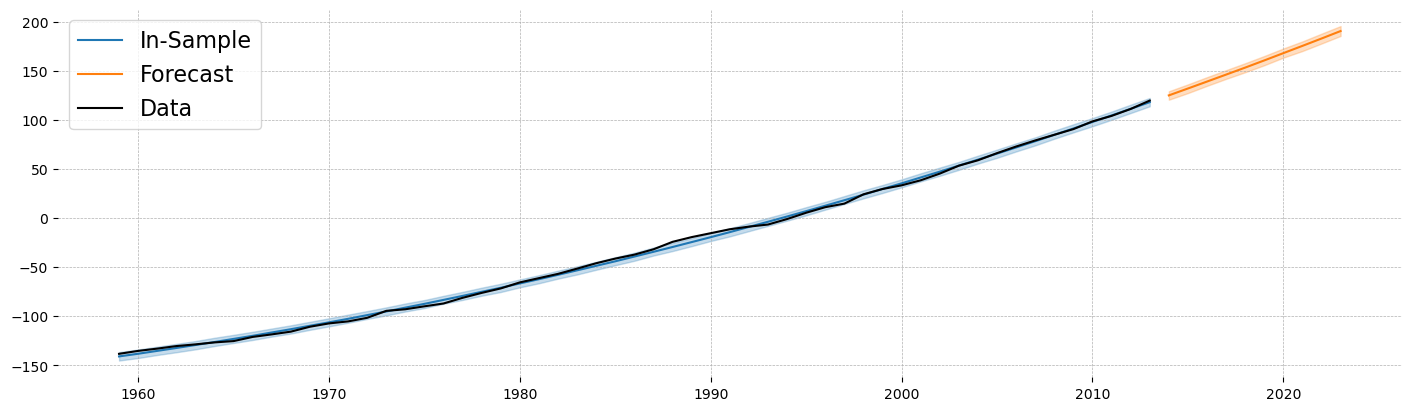

In [20]:
# We'll re-use these
def make_plot_iter():
    plotting_groups = ['posterior_predictive', 'predictions', 'constant_data']
    var_names = ['y_hat', 'y_hat', 'y_obs']
    plotting_colors = ['tab:blue', 'tab:orange', 'k']
    labels = ['In-Sample', 'Forecast', 'Data']
    return zip(plotting_groups, var_names, labels, plotting_colors)

fig, ax = plt.subplots()
for group, var_name, label, var_color in make_plot_iter():
    data = getattr(det_trend_idata, group)
    time_values = data.coords['time'].values
    if group != 'constant_data':
        hdi = az.hdi(data)[var_name]
        data = data.mean(dim=['chain', 'draw'])
        ax.fill_between(time_values, *hdi.values.T, color=var_color, alpha=0.25)
    ax.plot(time_values, data[var_name].values, c=var_color, label=label)
    ax.legend(fontsize=16)

# Combined

<Axes: xlabel='Date'>

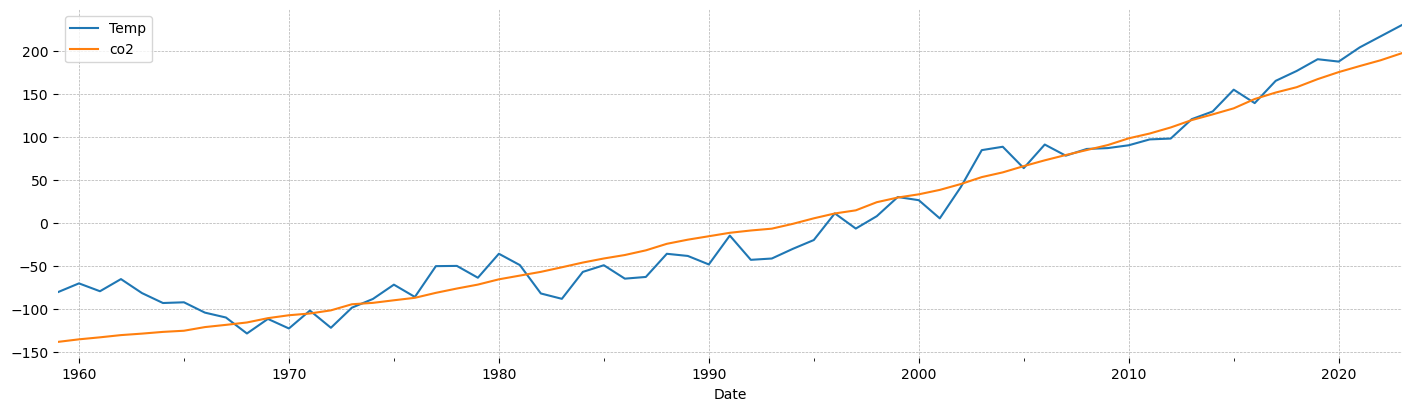

In [21]:
df.plot()

In [22]:
train_df, test_df = df.iloc[:round(len(df)*.85)], df.iloc[round(len(df)*.85):]

In [23]:
Y1 = train_df['Temp'].values
Y2 = train_df['co2'].values

Y = np.column_stack((Y1, Y2))

with pm.Model() as sur_model:

    t = pm.Data('t', np.arange(train_df.shape[0]), dims=['time'])
    
    # Priors for the intercepts and slopes of both series
    alpha1 = pm.Normal('alpha1', mu=-100, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    delta1 = pm.Normal('delta1', mu=0, sigma=10)
    
    alpha2 = pm.Normal('alpha2', mu=-150, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)
    delta2 = pm.Normal('delta2', mu=0, sigma=10)

    mu1 = pm.Deterministic('mu1', alpha1 + beta1 * t + delta1 * t * t, dims=['time'])
    mu2 = pm.Deterministic('mu2', alpha2 + beta2 * t + delta2 * t * t, dims=['time'])
    
    # Stack the means to create a matrix of shape (n, 2)
    mu = pm.math.stack([mu1, mu2], axis=-1)
    
    # Define the covariance matrix for the errors
    sd_dist = pm.Exponential.dist(1.0)
    chol, corr, sigmas = pm.LKJCholeskyCov(
        'chol_cov', n=2, eta=2, sd_dist=sd_dist, compute_corr=True
    )
    
    # Likelihood with correlated errors
    obs = pm.MvNormal('obs', mu=mu, chol=chol, observed=Y)
    
    # Sampling
    det_trend_idata = pm.sample()
    det_trend_idata = pm.sample_posterior_predictive(det_trend_idata, **POST_PRED_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha1, beta1, delta1, alpha2, beta2, delta2, chol_cov]


Output()

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 90 seconds.
Sampling: [obs]


Output()

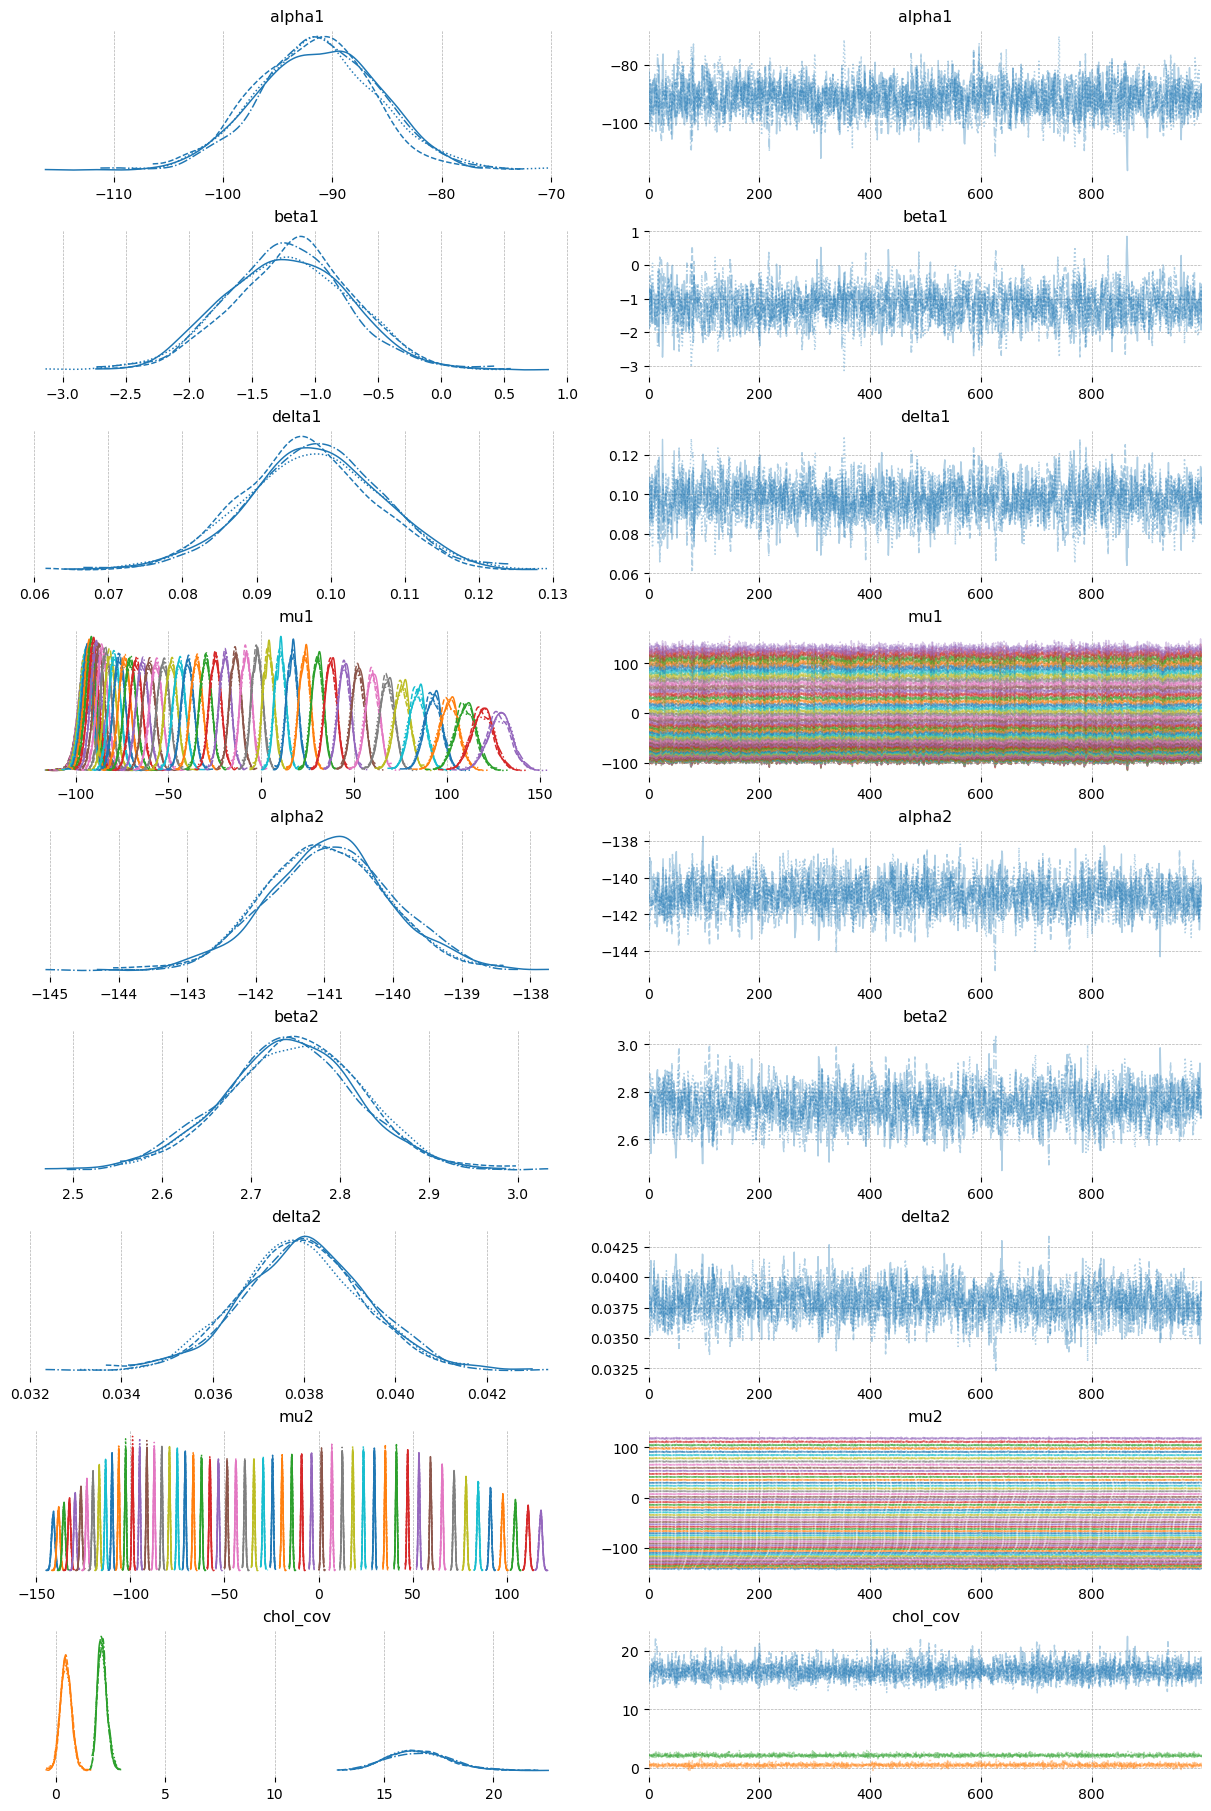

In [24]:
az.plot_trace(det_trend_idata, var_names=['alpha1','beta1','delta1','mu1','alpha2','beta2','delta2','mu2','chol_cov']);

In [26]:
corr_samples = det_trend_idata.posterior['chol_cov_corr'].values

corr_errors = corr_samples[:, :, 0, 1]  # Extracts the (1, 2) element of the correlation matrix
corr_errors_flat = corr_errors.flatten()

mean_corr_errors = np.mean(corr_errors_flat)
print("Mean correlation of the errors between Temp and CO2:", mean_corr_errors)

hdi_bounds = az.hdi(corr_errors_flat, hdi_prob=0.95)  # 95% HDI
print("95% HDI for the correlation of the errors between Temp and CO2:", hdi_bounds)


Mean correlation of the errors between Temp and CO2: 0.20985027007009818
95% HDI for the correlation of the errors between Temp and CO2: [-0.01098079  0.41254038]
